In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score, make_scorer, roc_curve, roc_auc_score, auc
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler


from src.datasets import load_run_over_dataset
from src.shadow_learn import ShadowedSetEstimator, WILF2018Adapter
from src.metrics import my_auc_score, conservative_score, my_f1_score
from src.model_selection import model_comparison
from src.utils import create_logfile, log_last_execution, load_stored_csv, get_train_test_split

In [2]:
pd.set_option('display.max_columns', None)

In [30]:
sse = ShadowedSetEstimator(C0=0.01, C1=0.316228, sigma=0.1)
dataset_loader = lambda: load_run_over_dataset(target=0, template='macro-districts', without=['DATA'])
# X, X_train, y_train, X_test, y_test, label_train, label_test = get_train_test_split(dataset_loader, test_size=0.2)

In [31]:
X, y, data_labels, target = load_run_over_dataset(target=0, template='macro-districts', without=['DATA'])
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
sse.fit(X_train, y_train)

ShadowedSetEstimator(C0=0.01, C1=0.316228, sigma=0.1)

In [33]:
preds = sse.predict(X_test)

In [34]:
list(zip(y_test, preds))

[(-1, 0),
 (-1, 0),
 (-1, 0),
 (-1, 0),
 (-1, 0),
 (-1, 0),
 (-1, 0),
 (1, 0),
 (-1, 0),
 (1, 0),
 (1, 0),
 (-1, 0),
 (1, 0),
 (1, 0),
 (-1, 0),
 (1, 0),
 (-1, 0),
 (1, 0),
 (1, 0),
 (-1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0)]

In [35]:
conservative_score(y_test, preds)

0.46153846153846156

In [36]:
my_auc_score(y_test, preds)

0.5

In [37]:
# sensitivity
recall_score(y_test, preds, labels=[1], average='weighted')

0.0

In [38]:
# specificity
recall_score(y_test, preds, labels=[-1], average='weighted')

0.0

In [39]:
my_f1_score(y_test, preds, 'conservative')

0.0

In [25]:
new_preds = np.array([el if el == 1 else -1 for el in preds])
f1_score(y_test, new_preds)

0.0

# Test nested-cv

In [53]:
X, y, data_labels, target = load_run_over_dataset(target=0, template='macro-districts', without=['DATA'])

In [54]:
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
C0_range = np.concatenate((np.logspace(-2, 1, 2), []))
C1_range = np.concatenate((np.logspace(-2, 1, 2), []))
sigma_range = np.concatenate((np.logspace(-1, 2, 2), [0.01, 10.5556]))
param_grid = {'C0': C0_range, 'C1': C1_range, 'sigma': sigma_range}

scorings = {
    'conservative': make_scorer(conservative_score),
    'auc': make_scorer(my_auc_score)
}

In [55]:
gs = GridSearchCV(estimator=ShadowedSetEstimator(solver='gurobi-two-phases'),
                  param_grid=param_grid, scoring=scorings, cv=cv_inner, refit='conservative', n_jobs=2, verbose=1)
cross_validate(X=X, y=y, estimator=gs, scoring=scorings, cv=cv_outer, n_jobs=2, verbose=1)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   27.5s finished


{'fit_time': array([8.33373451, 8.23418212, 8.09509206, 8.01408386, 8.20986271]),
 'score_time': array([0.01854277, 0.01659083, 0.01561499, 0.01659179, 0.01661968]),
 'test_conservative': array([0.57692308, 0.65384615, 0.57692308, 0.5       , 0.5       ]),
 'test_auc': array([0.60119048, 0.6547619 , 0.54166667, 0.54761905, 0.51785714])}

# Test nested-cv 2

In [56]:
sse = ShadowedSetEstimator(C=10.0, psi=0.1, sigma=11.6667, solver='gurobi-single-phase')
X, y, data_labels, target = load_run_over_dataset(target=0, template='macro-districts', without=['DATA'])

In [57]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

In [58]:
sse.fit(X_train, y_train)
sse.predict(X)

array([ 0, -1, -1,  0, -1, -1,  1,  0,  0,  1,  0, -1, -1,  0,  0,  0, -1,
       -1,  0, -1, -1,  0, -1,  0,  0,  1, -1, -1,  1,  0,  0, -1, -1,  1,
        1,  0,  0, -1, -1,  1,  0,  0,  1, -1,  1,  0, -1,  0,  0,  1, -1,
        1,  1,  0,  0,  1, -1,  1,  1,  1,  1,  1,  0,  1,  1,  1, -1,  1,
        1,  0,  1, -1,  0,  1,  1,  0,  1,  1,  1,  1,  0,  0,  1, -1,  0,
       -1,  1, -1,  1,  0, -1,  0,  0, -1,  0,  0,  1,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  1, -1, -1, -1,  1, -1, -1,  0,  1, -1,  0,  0,  1,
        0,  0,  0,  1,  0, -1,  0,  0,  0,  1,  1])

# Test nested-cv 3

In [68]:
sse = ShadowedSetEstimator(C0=0.01, C1=10.0, sigma=0.1)
X, y, data_labels, target = load_run_over_dataset(target=1, template='macro-districts', without=['DATA'])
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [69]:
sse.fit(X_train, y_train)
preds = sse.predict(X_test)

In [70]:
list(zip(y_test, preds))

[(1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (1, 0),
 (-1, 0),
 (1, 0),
 (-1, 0),
 (-1, 0),
 (1, 0),
 (-1, 0),
 (-1, 0),
 (1, 0),
 (-1, 0),
 (1, 0),
 (-1, 0),
 (-1, 0),
 (1, 0),
 (-1, 0),
 (-1, 0),
 (-1, 0),
 (-1, 0),
 (-1, 0),
 (-1, 0)]

In [71]:
conservative_score(y_test, preds)

0.5384615384615384

In [72]:
my_auc_score(y_test, preds)

0.5

In [73]:
# sensitivity
recall_score(y_test, preds, labels=[1], average='weighted')

0.0

In [74]:
# specificity
recall_score(y_test, preds, labels=[-1], average='weighted')

0.0

In [75]:
my_f1_score(y_test, preds, 'conservative')

0.0

In [76]:
new_preds = np.array([el if el == 1 else -1 for el in preds])
f1_score(y_test, new_preds)

0.0

# Test f1-score metric

In [4]:
log = False
op = 'w'
separate_targets = True
create_logfile('vs_run_over', 'Started Model Comparisons on run over dataset', log)
random_state = 42

estimators = []
param_grids = []
dataset = [
    lambda: (lambda: load_run_over_dataset(target=target, template='macro-districts', without=['DATA']) for target in [0, 1]),
    [0, 1]
]
additional_test_metrics = {
    'auc': 'auc',
    'sensitivity': 'sensitivity',
    'specificity': 'specificity',
    'precision': 'custom-precision',
    'f1-score': 'f1-score',
    'shadow-ratio': 'shadow-ratio',
    'shadow-count': 'shadow-count'
}
rf = RandomForestClassifier(n_jobs=2, class_weight='balanced', max_depth=5, random_state=random_state)
# feature_selector = None
feature_selector = BorutaPy(rf, n_estimators='auto', verbose=0, perc=80, random_state=random_state)

gurobi_two_phases = ShadowedSetEstimator(solver='gurobi-two-phases')
gurobi_two_phases_param_grid = {'C0': np.concatenate((np.logspace(-1, 1, 1), [])),
                                'C1': np.concatenate((np.logspace(-1, 1, 1), [])),
                                'sigma': np.concatenate((np.logspace(-1, 2, 1), [0.01, 10.5556]))}
estimators.append(gurobi_two_phases)
param_grids.append(gurobi_two_phases_param_grid)

mdwdd_cons_df = model_comparison(dataset, estimators, 'conservative', param_grids,
                                 n_splits=5, cv_num=5, main_metric_name='conservative', scaled=True,
                                 additional_test_metrics=additional_test_metrics, filename='mdwdd_cons',
                                 separate_targets=separate_targets, nested=True, feature_selector=feature_selector,
                                 verbose=0, op='d', log=log)
mdwdd_cons_df

  0%|          | 0/1 [00:00<?, ?it/s]

nested_cv: CV_SCORES
{'fit_time': array([88.32842374, 95.77477717, 97.31812143, 87.1079917 , 75.08135152]), 'score_time': array([0.02049565, 0.02147174, 0.02342606, 0.02049494, 0.02635431]), 'estimator': (GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selector',
                                        BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                                                                  max_depth=5,
                                                                                  n_jobs=2,
                                                                                  random_state=42),
                                                 n_estimators='auto', perc=80,
                                                 random_state=42)),
                                       ('estimato

F:\Copia HD G\Universita\UNIMI\Th\PyCharm\shadowedSetLearn\src\model_selection.py:585: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  'scores': cv_scores, 'best_estimators': best_estimators, 'all_shadow_indices': np.array(all_shadow_indices),


model_comparison: DATASET LOADER, TARGET
<function <lambda>.<locals>.<genexpr>.<lambda> at 0x0000024E0D5EFA68> 0
model_comparison: CV_SCORES
{'mean': 0.5, 'std': 0.04865042554105196, 'scores': {'fit_time': array([88.32842374, 95.77477717, 97.31812143, 87.1079917 , 75.08135152]), 'score_time': array([0.02049565, 0.02147174, 0.02342606, 0.02049494, 0.02635431]), 'estimator': (GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selector',
                                        BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                                                                  max_depth=5,
                                                                                  n_jobs=2,
                                                                                  random_state=42),
                        

nested_cv: CV_SCORES
{'fit_time': array([89.51796603, 96.07318592, 95.64696741, 85.10054016, 73.28821111]), 'score_time': array([0.02049947, 0.02049518, 0.0175674 , 0.01756811, 0.01756787]), 'estimator': (GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selector',
                                        BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                                                                  max_depth=5,
                                                                                  n_jobs=2,
                                                                                  random_state=42),
                                                 n_estimators='auto', perc=80,
                                                 random_state=42)),
                                       ('estimato

F:\Copia HD G\Universita\UNIMI\Th\PyCharm\shadowedSetLearn\src\model_selection.py:585: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  'scores': cv_scores, 'best_estimators': best_estimators, 'all_shadow_indices': np.array(all_shadow_indices),


model_comparison: DATASET LOADER, TARGET
<function <lambda>.<locals>.<genexpr>.<lambda> at 0x0000024E19B21C18> 1
model_comparison: CV_SCORES


100%|##########| 1/1 [08:41<00:00, 521.06s/it]

{'mean': 0.5307692307692307, 'std': 0.015384615384615375, 'scores': {'fit_time': array([89.51796603, 96.07318592, 95.64696741, 85.10054016, 73.28821111]), 'score_time': array([0.02049947, 0.02049518, 0.0175674 , 0.01756811, 0.01756787]), 'estimator': (GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selector',
                                        BorutaPy(estimator=RandomForestClassifier(class_weight='balanced',
                                                                                  max_depth=5,
                                                                                  n_jobs=2,
                                                                                  random_state=42),
                                                 n_estimators='auto', perc=80,
                                                 random_state=42)),
  

conservative mean  conservative std  auc mean  \
GurobiTwoPhases (target = 0)           0.500000          0.048650  0.500000   
GurobiTwoPhases (target = 1)           0.530769          0.015385  0.527381   

                               auc std  sensitivity mean  sensitivity std  \
GurobiTwoPhases (target = 0)  0.076413          0.485714         0.397441   
GurobiTwoPhases (target = 1)  0.042691          0.316667         0.388730   

                              specificity mean  specificity std  \
GurobiTwoPhases (target = 0)          0.516667         0.399305   
GurobiTwoPhases (target = 1)          0.714286         0.352831   

                              precision mean  precision std  ...  \
GurobiTwoPhases (target = 0)        0.324286       0.265791  ...   
GurobiTwoPhases (target = 1)        0.195238       0.239235  ...   

                              f1-score std  shadow-ratio mean  \
GurobiTwoPhases (target = 0)      0.318311           0.115385   
GurobiTwoPhases (target = 1)      0.295430           0.153846   

                              shadow-ratio std  shadow-count mean  \
GurobiTwoPhases (target = 0)          0.153846                3.0   
GurobiTwoPhases (target = 1)          0.147964                4.0   

                              shadow-count std  all shadow ratio mean  \
GurobiTwoPhases (target = 0)          4.000000               0.215385   
GurobiTwoPhases (target = 1)          3.847077               0.292308   

                              all shadow ratio std  all shadow count mean  \
GurobiTwoPhases (target = 0)              0.265401                   28.0   
GurobiTwoPhases (target = 1)              0.240315                   38.0   

                              all shadow count std     time  
GurobiTwoPhases (target = 0)             34.502174  0:04:25  
GurobiTwoPhases (target = 1)             31.240999  0:04:15  

[2 rows x 21 columns]

In [6]:
mdwdd_cons_df

conservative mean  conservative std  auc mean  \
GurobiTwoPhases (target = 0)           0.500000          0.048650  0.500000   
GurobiTwoPhases (target = 1)           0.530769          0.015385  0.527381   

                               auc std  sensitivity mean  sensitivity std  \
GurobiTwoPhases (target = 0)  0.076413          0.485714         0.397441   
GurobiTwoPhases (target = 1)  0.042691          0.316667         0.388730   

                              specificity mean  specificity std  \
GurobiTwoPhases (target = 0)          0.516667         0.399305   
GurobiTwoPhases (target = 1)          0.714286         0.352831   

                              precision mean  precision std  f1-score mean  \
GurobiTwoPhases (target = 0)        0.324286       0.265791       0.388777   
GurobiTwoPhases (target = 1)        0.195238       0.239235       0.241212   

                              f1-score std  shadow-ratio mean  \
GurobiTwoPhases (target = 0)      0.318311           0.115385   
GurobiTwoPhases (target = 1)      0.295430           0.153846   

                              shadow-ratio std  shadow-count mean  \
GurobiTwoPhases (target = 0)          0.153846                3.0   
GurobiTwoPhases (target = 1)          0.147964                4.0   

                              shadow-count std  all shadow ratio mean  \
GurobiTwoPhases (target = 0)          4.000000               0.215385   
GurobiTwoPhases (target = 1)          3.847077               0.292308   

                              all shadow ratio std  all shadow count mean  \
GurobiTwoPhases (target = 0)              0.265401                   28.0   
GurobiTwoPhases (target = 1)              0.240315                   38.0   

                              all shadow count std     time  
GurobiTwoPhases (target = 0)             34.502174  0:04:25  
GurobiTwoPhases (target = 1)             31.240999  0:04:15

In [11]:
test_sensitivity = np.array([0.83333333, 0.        , 0.75      , 0.        , 0.        ])
test_precision = np.array([0.47619048, 0.        , 0.5       , 0.        , 0.        ])
f1_score = []
for sens, prec in zip(test_sensitivity, test_precision):
    denom = sens + prec
    numer = 2 * (sens * prec)
    if denom == 0:
        f1_score.append(0)
    else:
        f1_score.append(numer / denom)
    
f1_score = np.array(f1_score)
f1_score.mean(), f1_score.std(), f1_score

(0.24121212165289255,
 0.2954295255144419,
 array([0.60606061, 0.        , 0.6       , 0.        , 0.        ]))

In [12]:
test_f1_score = np.array([0.60606061, 0.        , 0.6       , 0.        , 0.        ])
test_f1_score.mean(), test_f1_score.std()

(0.241212122, 0.2954295259431114)

# Test sensitivity and specificity metrics

In [3]:
sse = ShadowedSetEstimator(solver='gurobi-two-phases', C1=0.1, sigma=0.1)
X, y, data_labels, target, _ = load_run_over_dataset(target=0, template='macro-districts', without=['DATA'])
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    if i == 4:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestClassifier(n_jobs=2, class_weight='balanced', max_depth=5, random_state=42)
feature_selector = BorutaPy(rf, n_estimators='auto', verbose=0, perc=80, random_state=42)

feature_selector.fit(X_train, y_train)
X_train = feature_selector.transform(X_train)
X_test = feature_selector.transform(X_test)

In [4]:
sse.fit(X_train, y_train)
preds = sse.predict(X_test)
list(zip(y_test, preds))


--------------------------------------------
--------------------------------------------

Using license file C:\Users\gabri\gurobi.lic
Academic license - for non-commercial use only - expires 2021-01-08


[(-1, 0),
 (-1, -1),
 (-1, 0),
 (-1, -1),
 (-1, 0),
 (-1, -1),
 (-1, 0),
 (1, 0),
 (-1, -1),
 (1, -1),
 (1, -1),
 (-1, -1),
 (1, -1),
 (1, 0),
 (-1, 0),
 (1, 0),
 (-1, -1),
 (1, -1),
 (1, -1),
 (-1, 0),
 (1, -1),
 (1, -1),
 (1, -1),
 (1, -1),
 (1, -1),
 (1, 0)]

In [7]:
conservative_score(y_test, preds)

0.46153846153846156

In [8]:
len([p for p in preds if p == 0])

10

In [9]:
len([p for p in preds if p == 0]) / len(preds)

0.38461538461538464

In [10]:
cons_preds = [1 if pred == 1 else -1 for pred in preds]
list(zip(y_test, cons_preds))

[(-1, -1),
 (-1, -1),
 (-1, -1),
 (-1, -1),
 (-1, -1),
 (-1, -1),
 (-1, -1),
 (1, -1),
 (-1, -1),
 (1, -1),
 (1, -1),
 (-1, -1),
 (1, -1),
 (1, -1),
 (-1, -1),
 (1, -1),
 (-1, -1),
 (1, -1),
 (1, -1),
 (-1, -1),
 (1, -1),
 (1, -1),
 (1, -1),
 (1, -1),
 (1, -1),
 (1, -1)]

In [11]:
tp = 0 
fn = 0
tn = 0
fp = 0
for t, p in zip(y_test, cons_preds):
    if t == 1:
        if t == p:
            tp = tp + 1
        else:
            fn = fn + 1
    elif t == -1:
        if t == p:
            tn = tn + 1
        else:
            fp = fp + 1
            
tp, fn, tn, fp

(0, 14, 12, 0)

In [12]:
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
sensitivity, specificity

(0.0, 1.0)

In [13]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
accuracy

0.46153846153846156

In [129]:
precision = tp / (tp + fp) if (tp + fp) != 0 else 0
precision

0

In [130]:
f1_score = 2 * tp / (2 * tp + fp + fn)
f1_score

0.0

In [131]:
roc_curve(y_test, cons_preds)

(array([0., 1.]), array([0., 1.]), array([ 0, -1]))

In [132]:
roc_auc_score(y_test, cons_preds)

0.5

In [133]:
roc_auc_score(y_test, preds)

0.3928571428571428

In [134]:
roc_auc_score(y_test, [1 if p == 1 else 0.5 if p == 0 else 0 for p in preds])

0.3928571428571428

In [135]:
roc_auc_score(y_test, [1 if p == 1 else 0 for p in cons_preds])

0.5

In [136]:
roc_auc_score(y_test, [1 if p == 1 else 0 if p == -1 else 0.5 for p in preds])

0.3928571428571428

In [137]:
list(zip(preds, [1 if p == 1 else 0 if p == -1 else 0.5 for p in preds], [1 if p == 1 else 0.5 if p == 0 else 0 for p in preds]))

[(0, 0.5, 0.5),
 (-1, 0, 0),
 (0, 0.5, 0.5),
 (-1, 0, 0),
 (0, 0.5, 0.5),
 (-1, 0, 0),
 (0, 0.5, 0.5),
 (0, 0.5, 0.5),
 (-1, 0, 0),
 (-1, 0, 0),
 (-1, 0, 0),
 (-1, 0, 0),
 (-1, 0, 0),
 (0, 0.5, 0.5),
 (0, 0.5, 0.5),
 (0, 0.5, 0.5),
 (-1, 0, 0),
 (-1, 0, 0),
 (-1, 0, 0),
 (0, 0.5, 0.5),
 (-1, 0, 0),
 (-1, 0, 0),
 (-1, 0, 0),
 (-1, 0, 0),
 (-1, 0, 0),
 (0, 0.5, 0.5)]

# Quick ROC tests

In [2]:
y_true = [1, 1, -1, 1, -1, -1]
y_pred = [1, -1, -1, 1, -1, -1]
y_pred2 = [1, 0, 0, 1, 0, 0]

In [3]:
roc_auc_score(y_true, y_pred), roc_auc_score(y_true, y_pred2)

(0.8333333333333333, 0.8333333333333333)

In [4]:
# y_true = [1, 1, -1, 1, -1, -1]
# y_pred = [1, 1, -1, -1, 1, 1]
# y_pred2 = [1, 1, 0, 0, 1, 1]

In [5]:
roc_auc_score(y_true, y_pred), roc_auc_score(y_true, y_pred2)

(0.8333333333333333, 0.8333333333333333)

In [6]:
fpr, tpr, _ = roc_curve(y_true, y_pred)

In [7]:
auc_score = auc(fpr, tpr)
auc_score

0.8333333333333333

In [8]:
roc_auc = roc_auc_score(y_true, y_pred)
roc_auc

0.8333333333333333

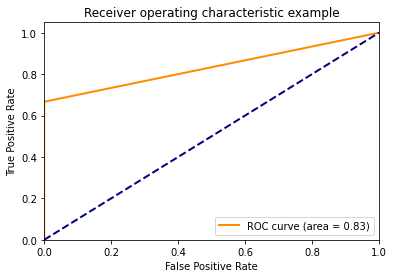

In [9]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

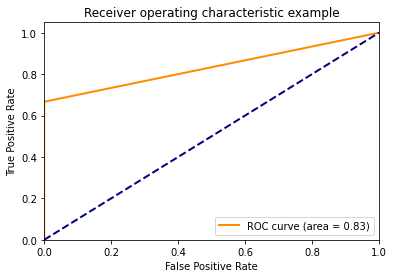

In [10]:
fpr, tpr, _ = roc_curve(y_true, y_pred2)
roc_auc = roc_auc_score(y_true, y_pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Quick ROC tests 2

In [27]:
y_true = np.array([1, 1, -1, 1, 0, -1, -1, 0])
y_pred = np.array([1, -1, -1, 1, 0, -1, -1, 0])
y_pred2 = np.array([1, 0, 0, 1, 0.5, 0, 0, 0.5])
y_pred3 = np.array([[0,0,1], [1,0,0], [1,0,0], [0,0,1], [0,1,0], [1,0,0], [1,0,0], [0,1,0]])

In [28]:
roc_auc_score(y_true, y_pred3, average='weighted', multi_class='ovo')

0.9114583333333333

In [29]:
roc_auc_score(y_true, y_pred3, average='macro', multi_class='ovo')

0.9166666666666666